In [ ]:
!pip install transformers

In [2]:
import os
from tqdm import tqdm
import pandas as pd
import pickle
import gc

# Dowload and process data

In [3]:
import requests
import zipfile

def download_file_from_dropbox(url, destination):
    r = requests.get(url)
    if r.status_code == 200:
        with open(destination, 'wb') as f:
            f.write(r.content)
    else:
        print(f"Failed to download file, status code: {r.status_code}")

def unzip_file(zip_filepath, dest_directory):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_directory)

dropbox_url = "https://www.dropbox.com/scl/fi/y289ys7a8vh4y6s12gbs3/dataset.pkl?rlkey=95ys68iuauaxzrgordycv7nlk&dl=1"
destination = 'dataset.pkl'
download_file_from_dropbox(dropbox_url, destination)

In [4]:
df = pd.read_pickle('dataset.pkl')
df = df.sample(frac=0.1, random_state=42)

In [5]:
df.head()

,lang,title,summary,article_count,event_date
id,,,,,
e_70176,zho,谷歌将关闭Bump应用 三个月前刚刚收购,网易科技讯1月2日消息，据国外媒体报道，在被谷歌收购三个月后， Bump公司将在本月底被谷歌...,7,16073
e_173662,spa,El Govern pide a Rajoy explicar su plan el sáb...,La plataforma más completa de información y se...,4,16091
e_20281,spa,Almunia prepara un pliego de cargos contra Gaz...,La plataforma más completa de información y se...,7,16082
e_181139,deu,Auswirkung der Bundeswehrreform - Patriotische...,Gengend Kameraden leiden besonders in den erst...,5,16099
e_12016,zho,ARM攻物聯網 台積電歡呼,全球矽智財（IP）大廠安謀國際（ARM）昨（24）日宣布， 攜手意法半導體（STM）合攻物聯...,2,16063


In [6]:
df.shape

(19605, 5)

In [7]:
epochs = 5
params = {
  'batch_size': 16,
  'shuffle': True,
  'num_workers': 2,
}

In [8]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tdata
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [9]:
bert_model = 'bert-base-multilingual-cased'

tokenizer = AutoTokenizer.from_pretrained(bert_model, padding=True, truncation=True, max_length=512)
model = BertForSequenceClassification.from_pretrained(bert_model, problem_type="regression", num_labels=1)
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
class Dataset(tdata.Dataset):
  def __init__(self, df, list_IDs):
    self.df = df.loc[list_IDs]
    self.list_IDs = list(self.df.index)

  def __len__(self):
    return len(self.list_IDs)

  def __getitem__(self, index):
    idx = self.list_IDs[index]
    row = self.df.loc[idx]

    article_count = torch.tensor([row['article_count']])

    title, summary = row['title'], row['summary']

    text = title + "\n---\n" + summary

    return text, article_count

In [11]:
train_ids, test_ids = train_test_split(df.index, test_size=0.2, random_state=42)

train_dataset = Dataset(df, train_ids)
test_dataset = Dataset(df, test_ids)

train_generator = tdata.DataLoader(train_dataset, **params)
test_generator = tdata.DataLoader(test_dataset, **params)

In [12]:
for epoch in range(epochs):
  model.train()
  for x, y in train_generator:
    x, y = tokenizer(x, return_tensors="pt", padding=True, truncation=True), y.to(device)

    for k in x.keys():
      x[k] = x[k].to(device)

    optimizer.zero_grad()

    outputs = model(**x).logits
    loss = criteria(outputs, y.float())
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    test_loss = []

    for x, y in test_generator:
      x, y = tokenizer(x, return_tensors="pt", padding=True, truncation=True), y.to(device)
      for k in x.keys():
        x[k] = x[k].to(device)

      outputs = model(**x).logits
      loss = criteria(outputs, y.float())
      test_loss.append(loss.item())

  print('Epoch: {}, Loss: {}'.format(epoch, np.mean(test_loss)))

Epoch: 0, Loss: 265.6833119353628
Epoch: 1, Loss: 266.74608407369476
Epoch: 2, Loss: 276.25245480421114
Epoch: 3, Loss: 267.08200165508237
Epoch: 4, Loss: 267.0258406739894


In [13]:
# Generate predictions and save them in a pandas dataframe along with their true values
model.eval()
with torch.no_grad():
  true = []
  prd = []
  for x, y in test_generator:
    x, y = tokenizer(x, return_tensors="pt", padding=True, truncation=True), y.to(device)

    for k in x.keys():
      x[k] = x[k].to(device)

    outputs = model(**x).logits
    true.append(y.cpu().numpy())
    prd.append(outputs.cpu().numpy())

true = np.concatenate(true)
prd = np.concatenate(prd)
outputs = pd.DataFrame({'true': true.flatten(), 'pred': prd.flatten()})
nonzero = outputs[outputs['pred'] > 0]

print(f"{round(100 * nonzero.shape[0] / outputs.shape[0], 2)}% are nonzero")
if nonzero.shape[0] > 0:
  nz_true, nz_pred = nonzero['true'], nonzero['pred']

  nz_error = np.sum(np.abs(nz_true - nz_pred)) / nonzero.shape[0]
  print(f"nonzero error: {round(nz_error, 2)}")

100.0% are nonzero
nonzero error: 7.64


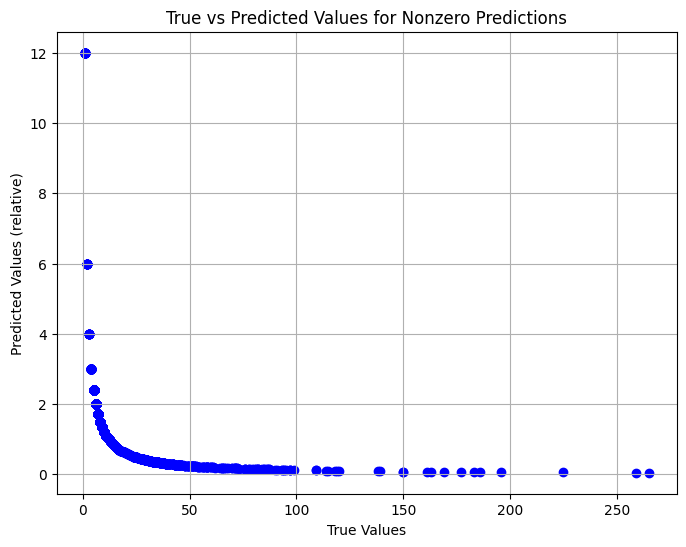

In [14]:
zero = outputs[outputs['pred'] == 0]

plt.figure(figsize=(8, 6))
plt.scatter(nonzero['true'], np.round(nonzero['pred']) / nonzero['true'], color='blue')
# plt.scatter(zero['true'], zero['pred'], color='red', label='Zero Predictions')
plt.title('True vs Predicted Values for Nonzero Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values (relative)')
plt.grid(True)
plt.show()

In [19]:
if zero.shape[0] != 0:
  plt.figure(figsize=(8, 6))

  # Determine the common range for both histograms
  min_true = min(zero['true'].min(), nonzero['true'].min())
  max_true = max(zero['true'].max(), nonzero['true'].max())

  # Define common bins for both histograms
  bins = np.linspace(min_true, max_true, 51)  # 50 bins between min and max

  # Plot both histograms
  plt.hist(zero['true'], bins=bins, color='green', edgecolor='black', alpha=0.5, label='Zero Predictions', rwidth=1)
  plt.hist(nonzero['true'], bins=bins, color='red', edgecolor='red', alpha=0.5, label='Non-Zero Predictions', rwidth=1)

  plt.title('Distribution of True Values')
  plt.xlabel('True Values')
  plt.ylabel('Frequency')

  # Customize x-axis ticks
  ax = plt.gca()  # Get current axis
  ax.xaxis.set_major_locator(ticker.MultipleLocator(10)) # Set interval of major ticks

  plt.legend()
  plt.grid(True)
  plt.show()

In [20]:
outputs

,true,pred
0,15,11.603659
1,7,11.603659
2,5,11.603659
3,9,11.603659
4,12,11.603659
...,...,...
3916,6,11.603659
3917,12,11.603659
3918,93,11.603659
3919,5,11.603659


In [ ]:
# get l1, mse and mape
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mae = mean_absolute_error(outputs['true'], outputs['pred'])
mse = mean_squared_error(outputs['true'], outputs['pred'])
mape = mean_absolute_percentage_error(outputs['true'], outputs['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}")